In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns
import os
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import datasets
import torch.utils.data as data

In [2]:
import os
import shutil
import cv2
import numpy as np

def resize_image(src_image, size=(128, 128), bg_color=(255, 255, 255)):
    # Resize the image while maintaining its aspect ratio
    h, w, _ = src_image.shape
    aspect_ratio = w / h
    new_w = size[0]
    new_h = int(new_w / aspect_ratio)
    if new_h > size[1]:
        new_h = size[1]
        new_w = int(new_h * aspect_ratio)

    resized_image = cv2.resize(src_image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a new square background image
    new_image = np.full((size[1], size[0], 3), bg_color, dtype=np.uint8)

    # Calculate the position to paste the resized image in the center
    x_offset = (size[0] - new_w) // 2
    y_offset = (size[1] - new_h) // 2

    # Paste the resized image into the center of the square background
    new_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_image

    return new_image

def resize_images_in_folder(input_folder, output_folder, size=(128, 128)):
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    for root, folders, files in os.walk(input_folder):
        for sub_folder in folders:
            # Create a matching subfolder in the output directory
            save_folder = os.path.join(output_folder, sub_folder)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            # Loop through the files in the subfolder
            file_names = os.listdir(os.path.join(root, sub_folder))
            for file_name in file_names:
                # Open the file
                file_path = os.path.join(root, sub_folder, file_name)
                image = cv2.imread(file_path)
                # Create a resized version and save it
                resized_image = resize_image(image, size)
                save_as = os.path.join(save_folder, file_name)
                cv2.imwrite(save_as, resized_image)

# Set the paths
input_images_path = 'natural_images'
resized_images_path = 'resized/natural_images'

# Define the image size
img_size = (128, 128)
classes = ["airplane", "car", "cat", "dog", "flower", "fruit", "motorbike", "person"]

# Call the function to resize images
resize_images_in_folder(input_images_path, resized_images_path, size=img_size)


In [3]:
def load_and_transform_images(data_path, batch_size=64, train_fraction=0.8, num_workers=0):
    # Define data transformations
    data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),  # Randomly flip horizontally
        transforms.RandomVerticalFlip(0.3),    # Randomly flip vertically
        transforms.ToTensor(),                 # Convert images to tensors
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
    ])

    # Load the dataset
    dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

    # Calculate the sizes for training and testing sets
    total_samples = len(dataset)
    train_size = int(train_fraction * total_samples)
    test_size = total_samples - train_size

    # Split the dataset into training and testing sets
    random_seed = 42
    train_dataset, test_dataset = train_test_split(dataset, test_size=1 - train_fraction, random_state=random_seed)

    # Split the training dataset into train and dev sets
    train_size = len(train_dataset)
    dev_size = int(train_size * 0.1)  # Adjust the fraction as needed
    train_size -= dev_size

    train_dataset, dev_dataset = data.random_split(train_dataset, [train_size, dev_size])

    # Create data loaders for the training, dev, and testing data
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    dev_loader = data.DataLoader(dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, dev_loader, test_loader

# Model 1

In [4]:
# Load the resized dataset
train_loader, dev_loader, test_loader = load_and_transform_images(resized_images_path)
batch_size = train_loader.batch_size  # You can get the batch size from the train_loader|

# Define the neural network model
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        # Define layers in the neural network
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.2)
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)
    
    def forward(self, x):
        # Forward pass through the network layers
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.dropout(self.drop(x), training=self.training)
        x = x.view(-1, 32 * 32 * 24)
        x = self.fc(x)
        return torch.log_softmax(x, dim=1)

# Model 2

In [5]:
class NetV1(nn.Module):
    def __init__(self, num_classes):
        super(NetV1, self).__init__()
        # Increased number of convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.3)

        # Increased number of neurons in the fully connected layer
        self.fc1 = nn.Linear(in_features=8 * 8 * 128, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
    
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))
        x = F.dropout(self.drop(x), training=self.training)
        x = x.view(-1, 8 * 8 * 128)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)


# Model 3

In [6]:
class NetV2(nn.Module):
    def __init__(self, num_classes):
        super(NetV2, self).__init__()
        # More convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.4)

        # Fully connected layers with more neurons
        self.fc1 = nn.Linear(in_features=8 * 8 * 128, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.pool(self.conv1(x))))
        x = F.relu(self.bn2(self.pool(self.conv2(x))))
        x = F.relu(self.bn3(self.pool(self.conv3(x))))
        x = F.relu(self.bn4(self.pool(self.conv4(x))))
        x = F.dropout(self.drop(x), training=self.training)
        x = x.view(-1, 8 * 8 * 128)  # Flatten for fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.log_softmax(x, dim=1)


In [7]:
# Determine if a GPU is available for training
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Create an instance of the model and allocate it to the device
model = Net(num_classes=len(classes)).to(device)
print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=8, bias=True)
)


# Training loop

In [8]:
# Function to train the model
def train(model, device, train_loader, optimizer, loss_criteria, epoch):
    model.train()
    train_loss = 0
    correct = 0
    # print("Epoch:", epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        correct += torch.sum(target == predicted).item()
        # print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
    
    avg_loss = train_loss / (batch_idx + 1)
    # print('Training set: Average loss: {:.6f}'.format(avg_loss))
    accuracy = 100. * correct / len(train_loader.dataset)
    
    return avg_loss, accuracy

# Function to test the model
def test(model, device, test_loader, loss_criteria):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        batch_count = 0
        
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target == predicted).item()
    
    avg_loss = test_loss / batch_count
    accuracy = 100. * correct / len(test_loader.dataset)
    # print('Testing set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(avg_loss, correct, len(test_loader.dataset), accuracy))
    
    return avg_loss, accuracy

# Function to test the model
def valid(model, device, dev_loader, loss_criteria):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        batch_count = 0
        
        for data, target in dev_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target == predicted).item()
    
    avg_loss = test_loss / batch_count
    accuracy = 100. * correct / len(dev_loader.dataset)
    # print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(avg_loss, correct, len(dev_loader.dataset), accuracy))
    
    return avg_loss, accuracy


# Optimizers

In [9]:
class sgd_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3): 
        super(sgd_optimizer, self).__init__(params, defaults={'lr': learning_rate})

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                p.data -= group['lr'] * p.grad.data

In [10]:
class momentum_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, beta = 0.9): 
        super(momentum_optimizer, self).__init__(params, defaults={'lr': learning_rate}) 
        self.beta = beta 
        self.state = dict() 
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(momentum = torch.zeros_like(p.data)) 

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(momentum = torch.zeros_like(p.data))
                v = self.beta * self.state[p]['momentum'] + group['lr'] * p.grad.data
                p.data -= v
                self.state[p]['momentum'] = v

In [11]:
class nag_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, beta = 0.9): 
        super(nag_optimizer, self).__init__(params, defaults={'lr': learning_rate}) 
        self.beta = beta 
        self.state = dict() 
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(momentum = torch.zeros_like(p.data)) 

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(momentum = torch.zeros_like(p.data))
                v = self.beta * (1 - group['lr']) * self.state[p]['momentum'] + group['lr'] * p.grad.data
                p.data -= v
                self.state[p]['momentum'] = v

In [12]:
class ada_grad_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, epsilon = 1e-7):
        super(ada_grad_optimizer, self).__init__(params, defaults={'lr': learning_rate}) 
        self.epsilon = epsilon 
        self.state = dict() 
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(lr_update = torch.zeros_like(p.data))

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(lr_update = torch.zeros_like(p.data))
                v = self.state[p]['lr_update'] + (p.grad.data)**2
                p.data -= group['lr'] * p.grad.data / torch.sqrt(v + self.epsilon)
                self.state[p]['lr_update'] = v

In [13]:
class rms_prop_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, epsilon = 1e-7, beta = 0.95):
        super(rms_prop_optimizer, self).__init__(params, defaults={'lr': learning_rate}) 
        self.epsilon = epsilon 
        self.state = dict()
        self.beta = beta
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(lr_update = torch.zeros_like(p.data))

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(lr_update = torch.zeros_like(p.data))
                v = self.beta * self.state[p]['lr_update'] + (1 - self.beta) * (p.grad.data)**2
                p.data -= group['lr'] * p.grad.data / torch.sqrt(v + self.epsilon)
                self.state[p]['lr_update'] = v

In [14]:
class adam_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, epsilon = 1e-7, beta1 = 0.9, beta2 = 0.99):
        super(adam_optimizer, self).__init__(params, defaults={'lr': learning_rate}) 
        self.epsilon = epsilon 
        self.state = dict()
        self.beta1 = beta1
        self.beta2 = beta2
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(lr_update = torch.zeros_like(p.data), momentum = torch.zeros_like(p.data), t = 0)

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(lr_update = torch.zeros_like(p.data), momentum = torch.zeros_like(p.data), t = 0)
                self.state[p]['t'] += 1
                v = self.beta2 * self.state[p]['lr_update'] + (1 - self.beta2) * (p.grad.data)**2
                m = self.beta1 * self.state[p]['momentum'] + (1 - self.beta1) * p.grad.data
                self.state[p]['lr_update'] = v
                self.state[p]['momentum'] = m
                m = m / (1 - self.beta1 ** self.state[p]['t'])
                v = v / (1 - self.beta2 ** self.state[p]['t'])
                p.data -= group['lr'] * m / torch.sqrt(v + self.epsilon)

In [15]:
class adam_w_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, epsilon = 1e-7, beta1 = 0.9, beta2 = 0.999, lambdaa = 0.01):
        super(adam_w_optimizer, self).__init__(params, defaults={'lr': learning_rate}) 
        self.epsilon = epsilon 
        self.state = dict()
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambdaa = lambdaa
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(lr_update = torch.zeros_like(p.data), momentum = torch.zeros_like(p.data), t = 0)

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(lr_update = torch.zeros_like(p.data), momentum = torch.zeros_like(p.data), t = 0)
                self.state[p]['t'] += 1
                v = self.beta2 * self.state[p]['lr_update'] + (1 - self.beta2) * (p.grad.data)**2
                m = self.beta1 * self.state[p]['momentum'] + (1 - self.beta1) * p.grad.data
                self.state[p]['lr_update'] = v
                self.state[p]['momentum'] = m
                m = m / (1 - self.beta1 ** self.state[p]['t'])
                v = v / (1 - self.beta2 ** self.state[p]['t'])
                p.data -= group['lr'] * (m / torch.sqrt(v + self.epsilon) + self.lambdaa * p.data)

In [16]:
class lion_optimizer(torch.optim.Optimizer): 

    def __init__(self, params, learning_rate = 1e-3, beta1 = 0.9, beta2 = 0.99, lambdaa = 0.01):
        super(lion_optimizer, self).__init__(params, defaults={'lr': learning_rate})
        self.state = dict()
        self.beta1 = beta1
        self.beta2 = beta2
        self.lambdaa = lambdaa
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(momentum = torch.zeros_like(p.data))

    def step(self): 
        for group in self.param_groups:
            for p in group['params']:
                if p not in self.state: 
                    self.state[p] = dict(momentum = torch.zeros_like(p.data))
                m = self.beta1 * self.state[p]['momentum'] + (1 - self.beta1) * p.grad.data
                p.data -= group['lr'] * (torch.sign(m) + self.lambdaa * p.data)
                m = self.beta2 * self.state[p]['momentum'] + (1 - self.beta2) * p.grad.data
                self.state[p]['momentum'] = m

In [17]:
# Determine if a GPU is available for training
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Create an instance of the model and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = lion_optimizer(model.parameters(), learning_rate = 0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
testing_loss = []
training_accuracy = []
validation_accuracy = []
testing_accuracy = []

# Train the model
epochs = 10  # You can adjust the number of epochs
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, loss_criteria)
    val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_accuracy)
    validation_accuracy.append(test_accuracy)
    testing_accuracy.append(val_accuracy)

Training on cuda


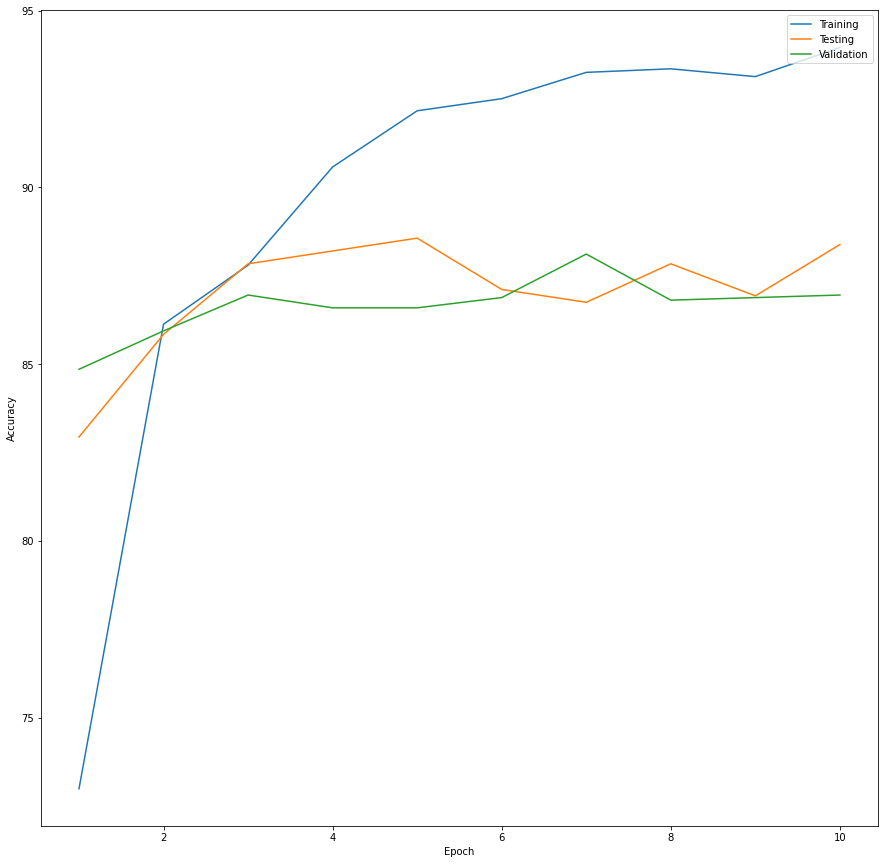

In [18]:
# Plot the training, testing and validation loss
plt.figure(figsize=(15, 15))
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, testing_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training','Testing' ,'Validation'], loc='upper right')
plt.show()

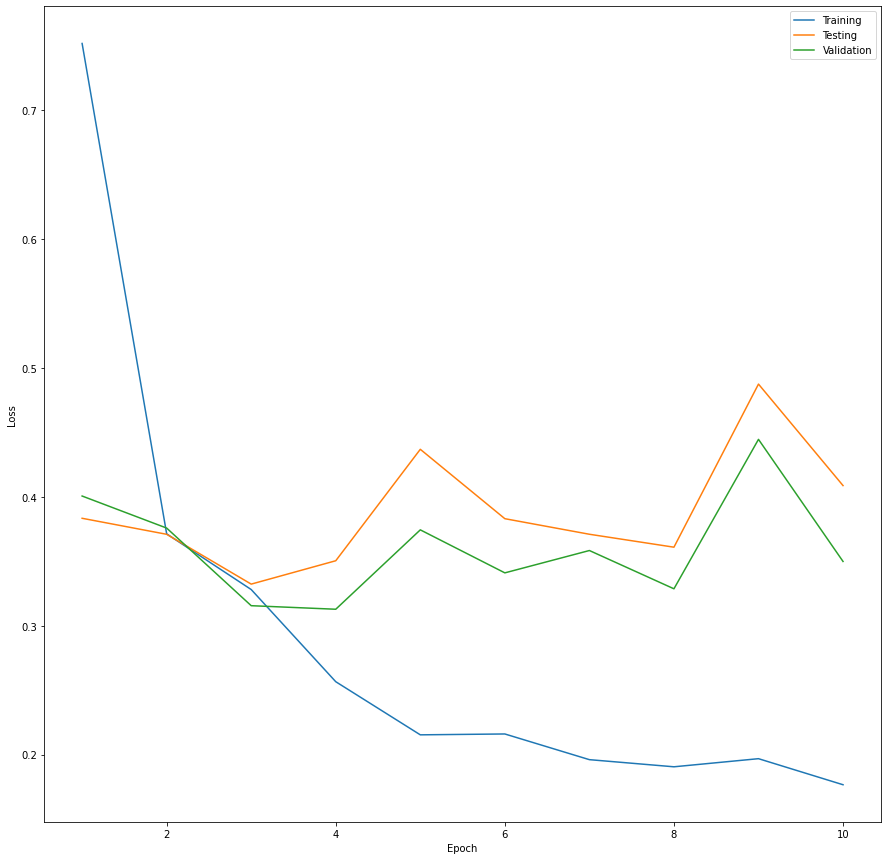

In [19]:
# Plot the training, testing and validation loss
plt.figure(figsize=(15, 15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, testing_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Testing', 'Validation'], loc='upper right')
plt.show()


In [30]:
# Determine if a GPU is available for training
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Create an instance of the model and allocate it to the device
model = NetV1(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = lion_optimizer(model.parameters(), learning_rate = 0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
testing_loss = []
training_accuracy = []
validation_accuracy = []
testing_accuracy = []

# Train the model
epochs = 10  # You can adjust the number of epochs
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, loss_criteria)
    val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_accuracy)
    validation_accuracy.append(test_accuracy)
    testing_accuracy.append(val_accuracy)

Training on cuda


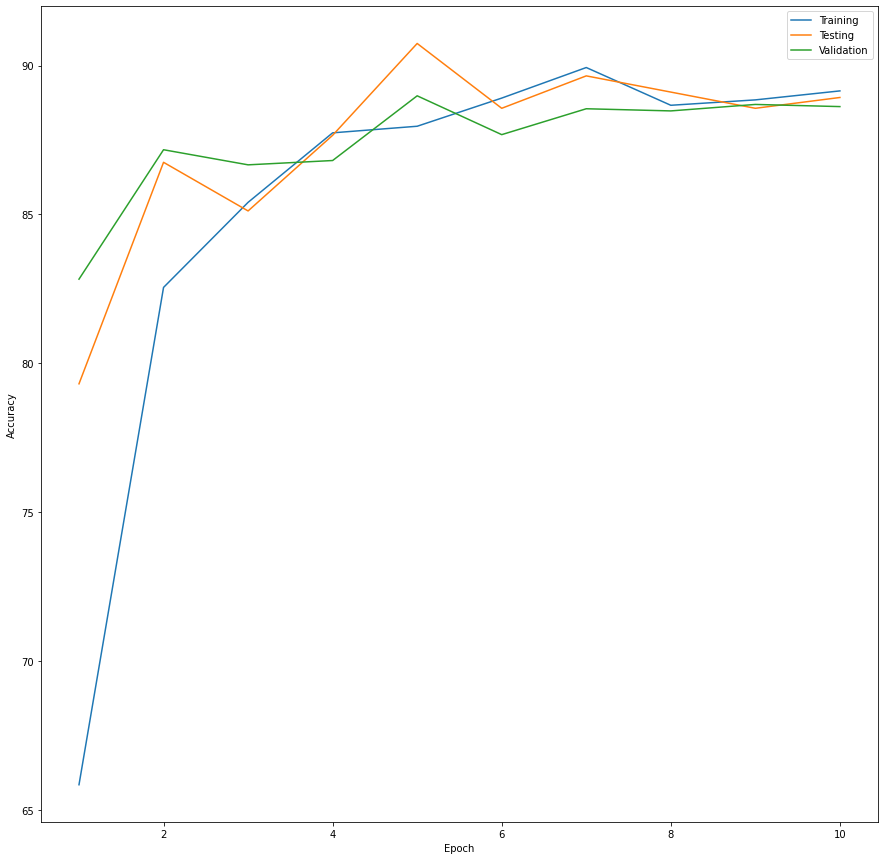

In [31]:
# Plot the training, testing and validation loss
plt.figure(figsize=(15, 15))
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, testing_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training','Testing' ,'Validation'], loc='upper right')
plt.show()

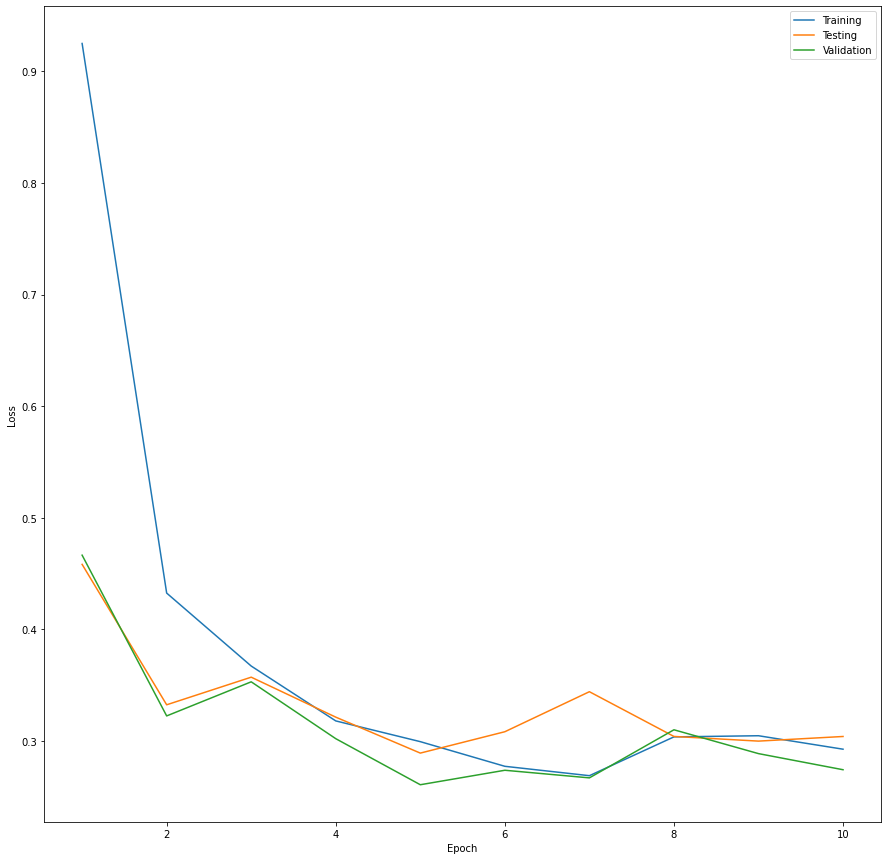

In [32]:
# Plot the training, testing and validation loss
plt.figure(figsize=(15, 15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, testing_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Testing', 'Validation'], loc='upper right')
plt.show()


In [33]:
# Determine if a GPU is available for training
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Create an instance of the model and allocate it to the device
model = NetV2(num_classes=len(classes)).to(device)

# Use an "Adam" optimizer to adjust weights
optimizer = lion_optimizer(model.parameters(), learning_rate = 0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
testing_loss = []
training_accuracy = []
validation_accuracy = []
testing_accuracy = []

# Train the model
epochs = 10  # You can adjust the number of epochs
print('Training on', device)
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, loss_criteria)
    val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_accuracy)
    validation_accuracy.append(test_accuracy)
    testing_accuracy.append(val_accuracy)

Training on cuda


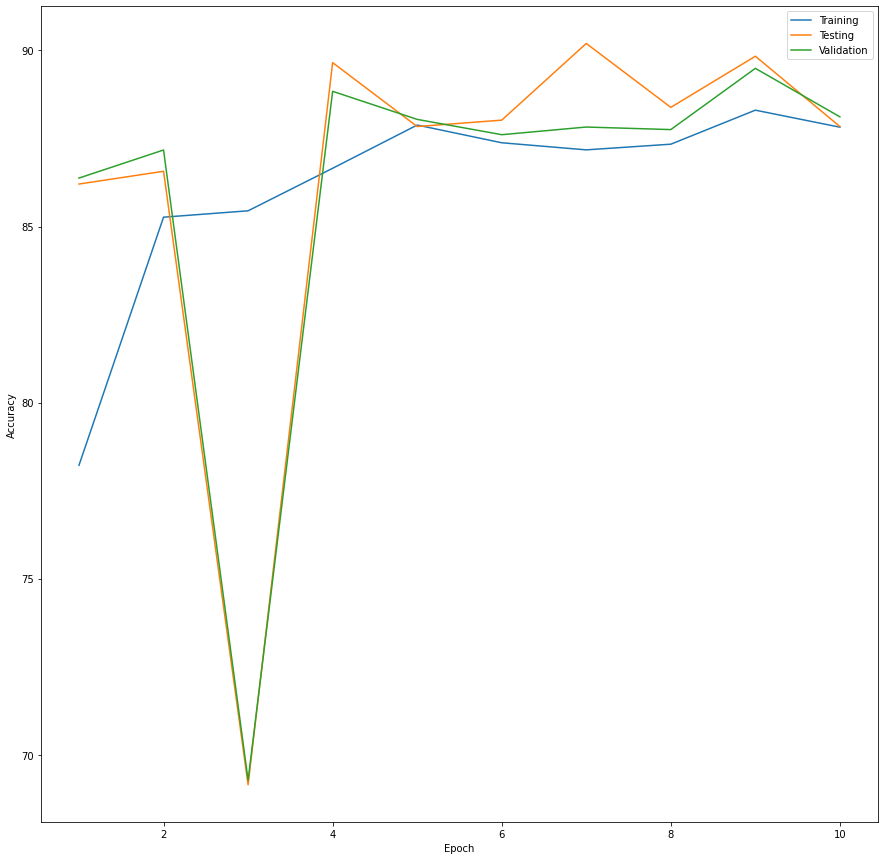

In [34]:
# Plot the training, testing and validation loss
plt.figure(figsize=(15, 15))
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, testing_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training','Testing' ,'Validation'], loc='upper right')
plt.show()

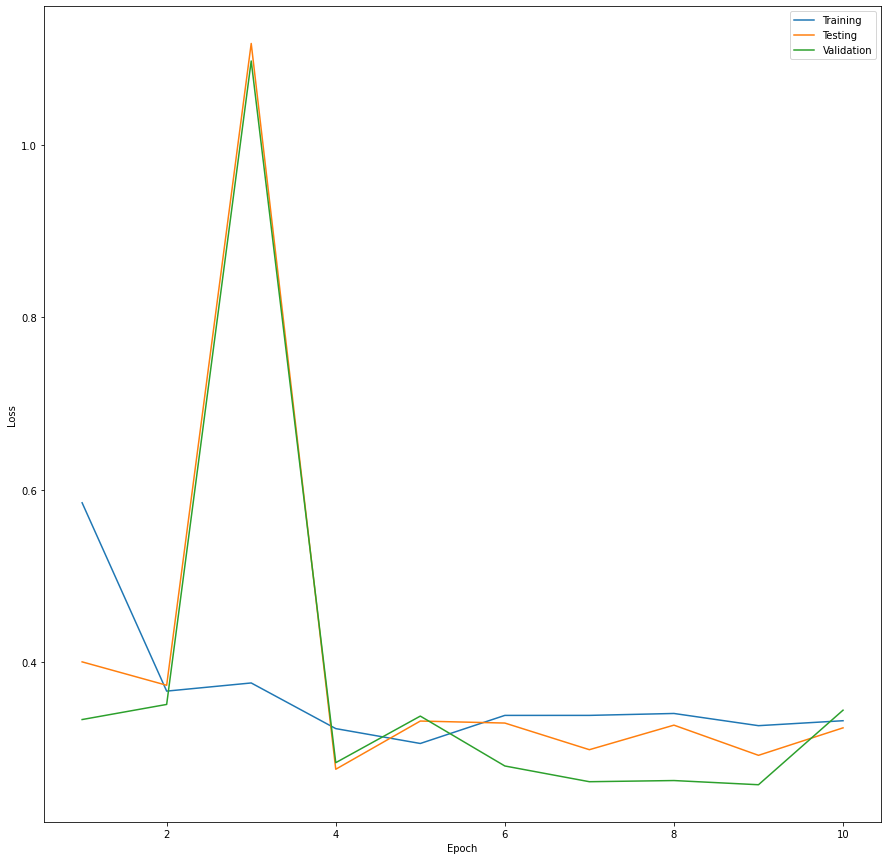

In [35]:
# Plot the training, testing and validation loss
plt.figure(figsize=(15, 15))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, testing_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Testing', 'Validation'], loc='upper right')
plt.show()


# Model Architecture Abalation

In [36]:
import matplotlib.pyplot as plt
import numpy as np

In [37]:
lr = 0.01
epochs = 15

models_name = ["Model1", "Model2", "Model3"]

sgd_modelArchirecture_ablation_train_loss = {}
sgd_modelArchirecture_ablation_valid_loss = {}
sgd_modelArchirecture_ablation_train_accuracy = {}
sgd_modelArchirecture_ablation_valid_accuracy = {}

loss_criteria = nn.CrossEntropyLoss()

for model_name in models_name:
    if model_name == "Model1":
        model = Net(num_classes=len(classes)).to(device)
    elif model_name == "Model2":
        model = NetV1(num_classes=len(classes)).to(device)
    elif model_name == "Model3":
        model = NetV2(num_classes=len(classes)).to(device)

    optimizer = sgd_optimizer(model.parameters(), learning_rate=lr)
    
    sgd_modelArchirecture_ablation_train_loss[model_name] = []
    sgd_modelArchirecture_ablation_valid_loss[model_name] = []
    sgd_modelArchirecture_ablation_train_accuracy[model_name] = []
    sgd_modelArchirecture_ablation_valid_accuracy[model_name] = []
            
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
        val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)

        sgd_modelArchirecture_ablation_train_loss[model_name].append(train_loss)
        sgd_modelArchirecture_ablation_valid_loss[model_name].append(val_loss)
        sgd_modelArchirecture_ablation_train_accuracy[model_name].append(train_accuracy)
        sgd_modelArchirecture_ablation_valid_accuracy[model_name].append(val_accuracy)
        

In [38]:
import json

# Save the dictionary to a file
with open('sgd_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(sgd_modelArchirecture_ablation_train_loss, file)


# Save the dictionary to a file
with open('sgd_modelArchirecture_ablation_valid_loss.json', 'w') as file:
    json.dump(sgd_modelArchirecture_ablation_valid_loss, file)


# Save the dictionary to a file
with open('sgd_modelArchirecture_ablation_train_accuracy.json', 'w') as file:
    json.dump(sgd_modelArchirecture_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('sgd_modelArchirecture_ablation_valid_accuracy.json', 'w') as file:
    json.dump(sgd_modelArchirecture_ablation_valid_accuracy, file)


In [39]:
lr = 0.01
epochs = 15

models_name = ["Model1", "Model2", "Model3"]

beta = 0.85
momentum_modelArchirecture_ablation_train_loss = {}
momentum_modelArchirecture_ablation_valid_loss = {}
momentum_modelArchirecture_ablation_train_accuracy = {}
momentum_modelArchirecture_ablation_valid_accuracy = {}

loss_criteria = nn.CrossEntropyLoss()

for model_name in models_name:
    if model_name == "Model1":
        model = Net(num_classes=len(classes)).to(device)
    elif model_name == "Model2":
        model = NetV1(num_classes=len(classes)).to(device)
    elif model_name == "Model3":
        model = NetV2(num_classes=len(classes)).to(device)
        
    optimizer = momentum_optimizer(model.parameters(), learning_rate=lr, beta=beta)
    
    momentum_modelArchirecture_ablation_train_loss[model_name] = []
    momentum_modelArchirecture_ablation_valid_loss[model_name] = []
    momentum_modelArchirecture_ablation_train_accuracy[model_name] = []
    momentum_modelArchirecture_ablation_valid_accuracy[model_name] = []
            
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
        val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)

        momentum_modelArchirecture_ablation_train_loss[model_name].append(train_loss)
        momentum_modelArchirecture_ablation_valid_loss[model_name].append(val_loss)
        momentum_modelArchirecture_ablation_train_accuracy[model_name].append(train_accuracy)
        momentum_modelArchirecture_ablation_valid_accuracy[model_name].append(val_accuracy)
        
        


In [40]:
import json

# Save the dictionary to a file
with open('momentum_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(momentum_modelArchirecture_ablation_train_loss, file)


# Save the dictionary to a file
with open('momentum_modelArchirecture_ablation_valid_loss.json', 'w') as file:
    json.dump(momentum_modelArchirecture_ablation_valid_loss, file)


# Save the dictionary to a file
with open('momentum_modelArchirecture_ablation_train_accuracy.json', 'w') as file:
    json.dump(momentum_modelArchirecture_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('momentum_modelArchirecture_ablation_valid_accuracy.json', 'w') as file:
    json.dump(momentum_modelArchirecture_ablation_valid_accuracy, file)


In [41]:
lr = 0.01
epochs = 15

models_name = ["Model1", "Model2", "Model3"]

beta = 0.85
nag_modelArchirecture_ablation_train_loss = {}
nag_modelArchirecture_ablation_valid_loss = {}
nag_modelArchirecture_ablation_train_accuracy = {}
nag_modelArchirecture_ablation_valid_accuracy = {}

loss_criteria = nn.CrossEntropyLoss()

for model_name in models_name:
    if model_name == "Model1":
        model = Net(num_classes=len(classes)).to(device)
    elif model_name == "Model2":
        model = NetV1(num_classes=len(classes)).to(device)
    elif model_name == "Model3":
        model = NetV2(num_classes=len(classes)).to(device)
        
    optimizer = nag_optimizer(model.parameters(), learning_rate=lr, beta=beta)
    
    nag_modelArchirecture_ablation_train_loss[model_name] = []
    nag_modelArchirecture_ablation_valid_loss[model_name] = []
    nag_modelArchirecture_ablation_train_accuracy[model_name] = []
    nag_modelArchirecture_ablation_valid_accuracy[model_name] = []
            
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
        val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)

        nag_modelArchirecture_ablation_train_loss[model_name].append(train_loss)
        nag_modelArchirecture_ablation_valid_loss[model_name].append(val_loss)
        nag_modelArchirecture_ablation_train_accuracy[model_name].append(train_accuracy)
        nag_modelArchirecture_ablation_valid_accuracy[model_name].append(val_accuracy)
        


In [42]:
import json

# Save the dictionary to a file
with open('nag_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(nag_modelArchirecture_ablation_train_loss, file)


# Save the dictionary to a file
with open('nag_modelArchirecture_ablation_valid_loss.json', 'w') as file:
    json.dump(nag_modelArchirecture_ablation_valid_loss, file)


# Save the dictionary to a file
with open('nag_modelArchirecture_ablation_train_accuracy.json', 'w') as file:
    json.dump(nag_modelArchirecture_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('nag_modelArchirecture_ablation_valid_accuracy.json', 'w') as file:
    json.dump(nag_modelArchirecture_ablation_valid_accuracy, file)


In [43]:
lr = 0.01
epochs = 15

models_name = ["Model1", "Model2", "Model3"]

epsilon = 1e-5
ada_grad_modelArchirecture_ablation_train_loss = {}
ada_grad_modelArchirecture_ablation_valid_loss = {}
ada_grad_modelArchirecture_ablation_train_accuracy = {}
ada_grad_modelArchirecture_ablation_valid_accuracy = {}

loss_criteria = nn.CrossEntropyLoss()

for model_name in models_name:
    if model_name == "Model1":
        model = Net(num_classes=len(classes)).to(device)
    elif model_name == "Model2":
        model = NetV1(num_classes=len(classes)).to(device)
    elif model_name == "Model3":
        model = NetV2(num_classes=len(classes)).to(device)
        
    optimizer = ada_grad_optimizer(model.parameters(), learning_rate=lr, epsilon=epsilon)
    
    ada_grad_modelArchirecture_ablation_train_loss[model_name] = []
    ada_grad_modelArchirecture_ablation_valid_loss[model_name] = []
    ada_grad_modelArchirecture_ablation_train_accuracy[model_name] = []
    ada_grad_modelArchirecture_ablation_valid_accuracy[model_name] = []
            
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
        val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)

        ada_grad_modelArchirecture_ablation_train_loss[model_name].append(train_loss)
        ada_grad_modelArchirecture_ablation_valid_loss[model_name].append(val_loss)
        ada_grad_modelArchirecture_ablation_train_accuracy[model_name].append(train_accuracy)
        ada_grad_modelArchirecture_ablation_valid_accuracy[model_name].append(val_accuracy)
        



In [44]:
import json

# Save the dictionary to a file
with open('ada_grad_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(ada_grad_modelArchirecture_ablation_train_loss, file)


# Save the dictionary to a file
with open('ada_grad_modelArchirecture_ablation_valid_loss.json', 'w') as file:
    json.dump(ada_grad_modelArchirecture_ablation_valid_loss, file)


# Save the dictionary to a file
with open('ada_grad_modelArchirecture_ablation_train_accuracy.json', 'w') as file:
    json.dump(ada_grad_modelArchirecture_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('ada_grad_modelArchirecture_ablation_valid_accuracy.json', 'w') as file:
    json.dump(ada_grad_modelArchirecture_ablation_valid_accuracy, file)


In [46]:
lr = 0.01
epochs = 15

models_name = ["Model1", "Model2", "Model3"]

epsilon = 1e-7
beta = 0.9
rmsprop_modelArchirecture_ablation_train_loss = {}
rmsprop_modelArchirecture_ablation_valid_loss = {}
rmsprop_modelArchirecture_ablation_train_accuracy = {}
rmsprop_modelArchirecture_ablation_valid_accuracy = {}

loss_criteria = nn.CrossEntropyLoss()

for model_name in models_name:
    if model_name == "Model1":
        model = Net(num_classes=len(classes)).to(device)
    elif model_name == "Model2":
        model = NetV1(num_classes=len(classes)).to(device)
    elif model_name == "Model3":
        model = NetV2(num_classes=len(classes)).to(device)
        
    model = Net(num_classes=len(classes)).to(device)
    optimizer = rms_prop_optimizer(model.parameters(), learning_rate=lr, epsilon=epsilon, beta=beta)
    
    rmsprop_modelArchirecture_ablation_train_loss[model_name] = []
    rmsprop_modelArchirecture_ablation_valid_loss[model_name] = []
    rmsprop_modelArchirecture_ablation_train_accuracy[model_name] = []
    rmsprop_modelArchirecture_ablation_valid_accuracy[model_name] = []
            
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
        val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)

        rmsprop_modelArchirecture_ablation_train_loss[model_name].append(train_loss)
        rmsprop_modelArchirecture_ablation_valid_loss[model_name].append(val_loss)
        rmsprop_modelArchirecture_ablation_train_accuracy[model_name].append(train_accuracy)
        rmsprop_modelArchirecture_ablation_valid_accuracy[model_name].append(val_accuracy)



In [47]:
import json

# Save the dictionary to a file
with open('rmsprop_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(rmsprop_modelArchirecture_ablation_train_loss, file)


# Save the dictionary to a file
with open('rmsprop_modelArchirecture_ablation_valid_loss.json', 'w') as file:
    json.dump(rmsprop_modelArchirecture_ablation_valid_loss, file)


# Save the dictionary to a file
with open('rmsprop_modelArchirecture_ablation_train_accuracy.json', 'w') as file:
    json.dump(rmsprop_modelArchirecture_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('rmsprop_modelArchirecture_ablation_valid_accuracy.json', 'w') as file:
    json.dump(rmsprop_modelArchirecture_ablation_valid_accuracy, file)


In [48]:
learning_rates = 0.01
epochs = 15

epsilon = 0.000001
beta1 = 0.9
beta2 = 0.999

adam_modelArchirecture_ablation_train_loss = {}
adam_modelArchirecture_ablation_valid_loss = {}
adam_modelArchirecture_ablation_train_accuracy = {}
adam_modelArchirecture_ablation_valid_accuracy = {}

loss_criteria = nn.CrossEntropyLoss()

for model_name in models_name:
    if model_name == "Model1":
        model = Net(num_classes=len(classes)).to(device)
    elif model_name == "Model2":
        model = NetV1(num_classes=len(classes)).to(device)
    elif model_name == "Model3":
        model = NetV2(num_classes=len(classes)).to(device)
    optimizer = adam_optimizer(model.parameters(), learning_rate=lr, epsilon=epsilon, beta1=beta1, beta2=beta2)
    
    adam_modelArchirecture_ablation_train_loss[model_name] = []
    adam_modelArchirecture_ablation_valid_loss[model_name] = []
    adam_modelArchirecture_ablation_train_accuracy[model_name] = []
    adam_modelArchirecture_ablation_valid_accuracy[model_name] = []
            
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
        val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)

        adam_modelArchirecture_ablation_train_loss[model_name].append(train_loss)
        adam_modelArchirecture_ablation_valid_loss[model_name].append(val_loss)
        adam_modelArchirecture_ablation_train_accuracy[model_name].append(train_accuracy)
        adam_modelArchirecture_ablation_valid_accuracy[model_name].append(val_accuracy)

        


In [49]:
import json

# Save the dictionary to a file
with open('adam_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(adam_modelArchirecture_ablation_train_loss, file)


# Save the dictionary to a file
with open('adam_modelArchirecture_ablation_valid_loss.json', 'w') as file:
    json.dump(adam_modelArchirecture_ablation_valid_loss, file)


# Save the dictionary to a file
with open('adam_modelArchirecture_ablation_train_accuracy.json', 'w') as file:
    json.dump(adam_modelArchirecture_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('adam_modelArchirecture_ablation_valid_accuracy.json', 'w') as file:
    json.dump(adam_modelArchirecture_ablation_valid_accuracy, file)


In [50]:
lr = 0.01
epochs = 15

models_name = ["Model1", "Model2", "Model3"]

epsilon = 0.000001
beta1 = 0.9
beta2 = 0.999
lambdaa = 0.004

adam_w_modelArchirecture_ablation_train_loss = {}
adam_w_modelArchirecture_ablation_valid_loss = {}
adam_w_modelArchirecture_ablation_train_accuracy = {}
adam_w_modelArchirecture_ablation_valid_accuracy = {}

loss_criteria = nn.CrossEntropyLoss()

for model_name in models_name:
    if model_name == "Model1":
        model = Net(num_classes=len(classes)).to(device)
    elif model_name == "Model2":
        model = NetV1(num_classes=len(classes)).to(device)
    elif model_name == "Model3":
        model = NetV2(num_classes=len(classes)).to(device)
        
    optimizer = adam_w_optimizer(model.parameters(), learning_rate=lr, epsilon=epsilon, beta1=beta1, beta2=beta2, lambdaa=lambdaa)
    
    adam_w_modelArchirecture_ablation_train_loss[model_name] = []
    adam_w_modelArchirecture_ablation_valid_loss[model_name] = []
    adam_w_modelArchirecture_ablation_train_accuracy[model_name] = []
    adam_w_modelArchirecture_ablation_valid_accuracy[model_name] = []
            
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
        val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)

        adam_w_modelArchirecture_ablation_train_loss[model_name].append(train_loss)
        adam_w_modelArchirecture_ablation_valid_loss[model_name].append(val_loss)
        adam_w_modelArchirecture_ablation_train_accuracy[model_name].append(train_accuracy)
        adam_w_modelArchirecture_ablation_valid_accuracy[model_name].append(val_accuracy)
        



In [51]:
import json

# Save the dictionary to a file
with open('adam_w_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(adam_w_modelArchirecture_ablation_train_loss, file)


# Save the dictionary to a file
with open('adam_w_modelArchirecture_ablation_valid_loss.json', 'w') as file:
    json.dump(adam_w_modelArchirecture_ablation_valid_loss, file)


# Save the dictionary to a file
with open('adam_w_modelArchirecture_ablation_train_accuracy.json', 'w') as file:
    json.dump(adam_w_modelArchirecture_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('adam_w_modelArchirecture_ablation_valid_accuracy.json', 'w') as file:
    json.dump(adam_w_modelArchirecture_ablation_valid_accuracy, file)


In [18]:
lr = 0.0001
epochs = 15

models_name = ["Model1", "Model2", "Model3"]

beta1 = 0.9
beta2 = 0.99
lambdaa = 0.004

lion_modelArchirecture_ablation_train_loss = {}
lion_modelArchirecture_ablation_valid_loss = {}
lion_modelArchirecture_ablation_train_accuracy = {}
lion_modelArchirecture_ablation_valid_accuracy = {}

loss_criteria = nn.CrossEntropyLoss()

for model_name in models_name:
    if model_name == "Model1":
        model = Net(num_classes=len(classes)).to(device)
    elif model_name == "Model2":
        model = NetV1(num_classes=len(classes)).to(device)
    elif model_name == "Model3":
        model = NetV2(num_classes=len(classes)).to(device)
        
    optimizer = lion_optimizer(model.parameters(), learning_rate=lr, beta1=beta1, beta2=beta2, lambdaa=lambdaa)
    
    lion_modelArchirecture_ablation_train_loss[model_name] = []
    lion_modelArchirecture_ablation_valid_loss[model_name] = []
    lion_modelArchirecture_ablation_train_accuracy[model_name] = []
    lion_modelArchirecture_ablation_valid_accuracy[model_name] = []
            
    for epoch in range(1, epochs + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, loss_criteria, epoch)
        val_loss, val_accuracy = valid(model, device, dev_loader, loss_criteria)

        lion_modelArchirecture_ablation_train_loss[model_name].append(train_loss)
        lion_modelArchirecture_ablation_valid_loss[model_name].append(val_loss)
        lion_modelArchirecture_ablation_train_accuracy[model_name].append(train_accuracy)
        lion_modelArchirecture_ablation_valid_accuracy[model_name].append(val_accuracy)



In [19]:
import json

# Save the dictionary to a file
with open('lion_modelArchirecture_ablation_train_loss.json', 'w') as file:
    json.dump(lion_modelArchirecture_ablation_train_loss, file)


# Save the dictionary to a file
with open('lion_modelArchirecture_ablation_valid_loss.json', 'w') as file:
    json.dump(lion_modelArchirecture_ablation_valid_loss, file)


# Save the dictionary to a file
with open('lion_modelArchirecture_ablation_train_accuracy.json', 'w') as file:
    json.dump(lion_modelArchirecture_ablation_train_accuracy, file)


# Save the dictionary to a file
with open('lion_modelArchirecture_ablation_valid_accuracy.json', 'w') as file:
    json.dump(lion_modelArchirecture_ablation_valid_accuracy, file)


In [ ]:
modelArchirecture_ablation_trainloss_list = [sgd_modelArchirecture_ablation_train_loss, momentum_modelArchirecture_ablation_train_loss, nag_modelArchirecture_ablation_train_loss, ada_grad_modelArchirecture_ablation_train_loss, rmsprop_modelArchirecture_ablation_train_loss, adam_modelArchirecture_ablation_train_loss, adam_w_modelArchirecture_ablation_train_loss, lion_modelArchirecture_ablation_train_loss]
modelArchirecture_ablation_validloss_list = [sgd_modelArchirecture_ablation_valid_loss, momentum_modelArchirecture_ablation_valid_loss, nag_modelArchirecture_ablation_valid_loss, ada_grad_modelArchirecture_ablation_valid_loss, rmsprop_modelArchirecture_ablation_valid_loss, adam_modelArchirecture_ablation_valid_loss, adam_w_modelArchirecture_ablation_valid_loss, lion_modelArchirecture_ablation_valid_loss]
modelArchirecture_ablation_trainaccuracy_list = [sgd_modelArchirecture_ablation_train_accuracy, momentum_modelArchirecture_ablation_train_accuracy, nag_modelArchirecture_ablation_train_accuracy, ada_grad_modelArchirecture_ablation_train_accuracy, rmsprop_modelArchirecture_ablation_train_accuracy, adam_modelArchirecture_ablation_train_accuracy, adam_w_modelArchirecture_ablation_train_accuracy, lion_modelArchirecture_ablation_train_accuracy]
modelArchirecture_ablation_validaccuracy_list = [sgd_modelArchirecture_ablation_valid_accuracy, momentum_modelArchirecture_ablation_valid_accuracy, nag_modelArchirecture_ablation_valid_accuracy, ada_grad_modelArchirecture_ablation_valid_accuracy, rmsprop_modelArchirecture_ablation_valid_accuracy, adam_modelArchirecture_ablation_valid_accuracy, adam_w_modelArchirecture_ablation_valid_accuracy, lion_modelArchirecture_ablation_valid_accuracy]

In [ ]:
optimizers_list = ["sgd", "momentum", "nag", "ada_grad", "rmsprop", "adam", "adam_w", "lion"]

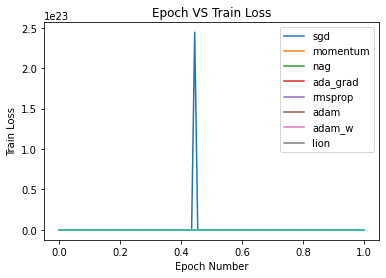

In [ ]:
import matplotlib.pyplot as plt

# Assuming data_list contains your dictionaries
for data_dict in modelArchirecture_ablation_trainloss_list:
    epochs = list(data_dict.keys())
    values = list(data_dict.values())
    plt.plot(epochs, values)

# Customize the plot (add labels, title, legend, etc. as needed)
plt.xlabel('Epoch Number')
plt.ylabel('Train Loss')
plt.title('Epoch VS Train Loss')
plt.legend([f'{optimizers_list[i]}' for i in range(len(modelArchirecture_ablation_trainloss_list))])

plt.savefig('line_graph_trainloss.png')
# Show the plot
plt.show()


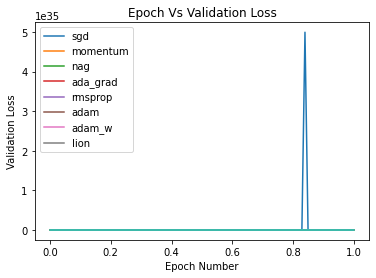

In [35]:
import matplotlib.pyplot as plt
# Assuming data_list contains your dictionaries
for data_dict in modelArchirecture_ablation_validloss_list:
    epochs = list(data_dict.keys())
    values = list(data_dict.values())
    plt.plot(epochs, values)

# Customize the plot (add labels, title, legend, etc. as needed)
plt.xlabel('Epoch Number')
plt.ylabel('Validation Loss')
plt.title('Epoch Vs Validation Loss')
plt.legend([f'{optimizers_list[i]}' for i in range(len(modelArchirecture_ablation_validloss_list))])

plt.savefig('line_graph_validloss.png')
# Show the plot
plt.show()


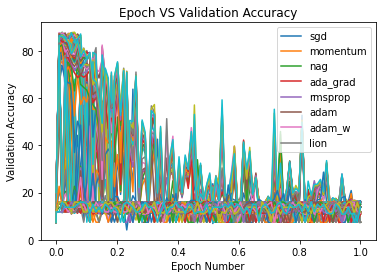

In [36]:
import matplotlib.pyplot as plt
# Assuming data_list contains your dictionaries
for data_dict in modelArchirecture_ablation_validaccuracy_list:
    epochs = list(data_dict.keys())
    values = list(data_dict.values())
    plt.plot(epochs, values)

# Customize the plot (add labels, title, legend, etc. as needed)
plt.xlabel('Epoch Number')
plt.ylabel('Validation Accuracy')
plt.title('Epoch VS Validation Accuracy')
plt.legend([f'{optimizers_list[i]}' for i in range(len(modelArchirecture_ablation_validaccuracy_list))])

            
plt.savefig('line_graph_validaccuracy.png')
# Show the plot
plt.show()


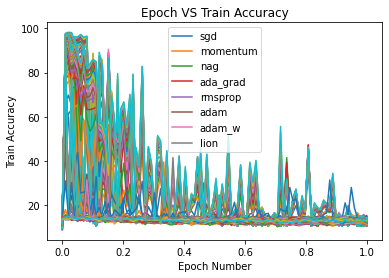

In [37]:
import matplotlib.pyplot as plt
# Assuming data_list contains your dictionaries
for data_dict in modelArchirecture_ablation_trainaccuracy_list:
    epochs = list(data_dict.keys())
    values = list(data_dict.values())
    plt.plot(epochs, values)

# Customize the plot (add labels, title, legend, etc. as needed)
plt.xlabel('Epoch Number')
plt.ylabel('Train Accuracy')
plt.title('Epoch VS Train Accuracy')
plt.legend([f'{optimizers_list[i]}' for i in range(len(modelArchirecture_ablation_trainaccuracy_list))])

plt.savefig('line_graph_trainaccuracy.png')
# Show the plot
plt.show()
